# Complex source reconstruction at fixed lens mass

__Author__ : Aymeric Galan

__Created__ : 23/04/20

__Updated__ : 31/08/20

This notebooks gives a working example of the modelling of a complex and realistic source with a pixel-based method based on sparsity and wavelets. The lens mass model is assumed to be exactly known, or at least a good approximation of it.

The source object, when modelled using the pixel-based method, is reconstructed iteratively on a grid of pixels, subject to constraints of __sparsity in starlet space__ and __positivity in direct space__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

__author__ = 'aymgal'

import os
import copy
import scipy
import pickle as pkl
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import time

from tqdm import tqdm

from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Analysis.image_reconstruction import MultiBandImageReconstruction
from lenstronomy.Plots import lens_plot, chain_plot
from lenstronomy.Util import mask_util
from lenstronomy.Util import image_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar, nice_colorbar_residuals, log_cmap
from slitronomy.Util import metrics_util

import fixed_param
import mass_util
import source_util
import psf_util

SEED = 18

%matplotlib inline

## Available settings

- `data_type`: type of imaging data
    - `'HST'`: relasitic simulation based on Hubble Space Telescope properties (WCF3 instrument in F160W band).  
    - `'ELT'`: relasitic simulation based on the future European Extremely Large Telescope (MICADO/MAORY instrument in H band).
- `complex_source_type`: choice of the source galaxy among:
    - `'highres-single'`: a single galaxy from HST high-res image (same as Time Delay Lens Modelling Challenge mocks).
    - `'highres-group'`: three interacting galaxies from HST high-res images.
- `perfect_seeing`: if `True`, no PSF effect are included in simulation nor modelling.

The following parameters can be set for the **pixel-based reconstruction**:
- `solve_pixelbased`: if `True`, solves the source reconstruction problem on pixelated grid (e.g. starlets). If `False`, will look for a backup pickle file for loading models (if found in /backups directory).
- `supersampling_factor_source`: image pixel size to source pixel size ratio, $r_{\rm pix}$ in the paper. Note that this also sets the resolution of the grid on which the _analytical_ reconstruction is projected on.

The following parameters can be set for the **analytical reconstruction**:
- `solve_analytical`: if `True`, solves with analytical profiles (e.g. shapelets). If `False`, will look for a backup pickle file for loading models (if found in /backups directory).
- `n_max_list`: list of maximum polynomial orders (list of $n_{\rm max}$) for each shapelet basis in the source model. The number of shapelets functions in the basis set is then $(n_{\rm max}+1)(n_{\rm max}+2)/2$.
- `optimizer_type`: `'SIMPLEX'` for a downhill simplex optimizer (faster), or `'PSO'` for a particle swarm optimizer (more efficient for large parameter space).
- `detect_components`: based on pixel-based model of the source, detect the number of source components and put individual additional shapelets basis centered on those.
- `refine_shapelets_orders`: automated iterative refinement of polynomial orders of each shapelet basis.
- `maximal_n_max`: maximal shapelet order allowed by the refinement process.
- `size_list`: if not `None`, rough estimation of characteristic radius of each source sub-component (associated to each shapelet sets).

<div class="alert alert-warning">
Note: when reconstructing the source with the analytical method, one uses a downhill simplex non-linear optimizer for finding the bets-fit parameters. This speeds upt considerably the computation time, compared to a particle swarm optimization (PSO). However, when using two shapelets basis sets in the source model, the simplex method seems to fail at finding the global minimum, so a PSO is required in this case.
</div>

In [2]:
# general settings
data_type = 'HST'  # 'HST', 'ELT'
complex_source_type = 'highres-single'  # 'highres-single', 'highres-group'
perfect_seeing = False

# pixel-based settings
solve_pixelbased = False  # if `False`, loads from backup 
supersampling_factor_source = 3

# analytical settings
solve_analytical = False  # if `False`, loads from backup
optimizer_type = 'PSO'  # 'SIMPLEX', 'PSO'
n_max_list = [8] #[3, 3, 9]
with_sersic = True
detect_components = False
refine_shapelets_orders = False
max_refine_steps, maximal_n_max, size_list = 3, 10, [0.3, 0.5, 1]

#### Choice of colormaps for image plots

In [ ]:
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = plt.get_cmap('cubehelix')
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.deepcopy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize negative pixels when in log scale

## Prepare for simulation

Several modules have been created:
- `fixed_param`: intrumental and lens configuration parameters.
- `mass_util`: functions for proper setup of lens model parameters.
- `psf_util`: functions to load and prepare pixelated PSFs.
- `source_util`: functions to load prepare realistic source objetcs.

### Load PSFs and instrument properties

In [4]:
# seeing specifics
if perfect_seeing:
    psf_type = 'NONE'
    psf_kernel = None
else:
    psf_type = 'PIXEL'
    if data_type == 'HST':
        psf_kernel = psf_util.get_HST_psf_kernel()
    elif data_type == 'ELT':
        psf_kernel = psf_util.get_ELT_psf_kernel()

# observational, instrumentation and numerical settings
kwargs_simulation, kwargs_numerics_simulation = fixed_param.get_simulation_kwargs(data_type, psf_type, psf_kernel)

# number of side pixels in cutout
delta_pix = kwargs_simulation['pixel_scale']
num_pix = int(fixed_param.cutout_size / delta_pix)
num_pix_source = int(num_pix*supersampling_factor_source)  # (maximum) number of side pixels for source plane


### Setup lens model, source position and magnitude

In [5]:
# lens model properties
lens_model_list, kwargs_lens = mass_util.get_lens_model_macro(fixed_param.sigma_v)

# main source galaxy properties
ra_source, dec_source = fixed_param.ra_source, fixed_param.dec_source
mag_source = fixed_param.mag_source

### Visualize lens model

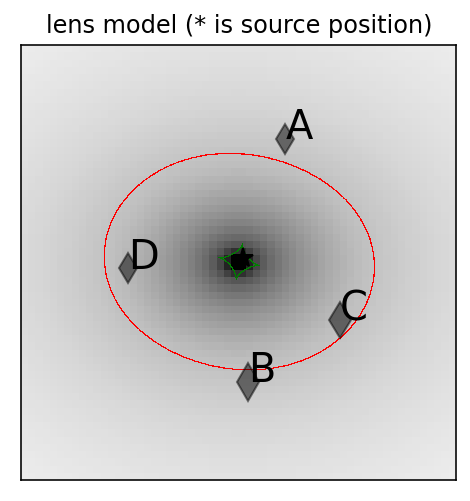

In [6]:
lens_model_class_plot = LensModel(lens_model_list=lens_model_list)

fig, ax = plt.subplots(1, 1)
ax.set_title("lens model (* is source position)")
lens_plot.lens_model_plot(ax, lens_model_class_plot, kwargs_lens, 
                          numPix=60, deltaPix=0.08,   # play with these to zoom in/out in the figure, or increase resolution
                          sourcePos_x=ra_source, sourcePos_y=dec_source,
                          point_source=True, with_caustics=True, coord_inverse=False)
plt.show()

### Setup the source surface brightness

In [7]:
if complex_source_type == 'highres-single':
    source_model_list, kwargs_source = source_util.prepare_highres_source(ra_source, dec_source, 
                                                                          galaxy_name=fixed_param.galaxy_name, 
                                                                          magnitude=fixed_param.mag_source)
elif complex_source_type == 'highres-group':
    source_model_list, kwargs_source = source_util.prepare_highres_source_multiple(fixed_param.pos_source_list, 
                                                                                   fixed_param.galaxy_name_list,
                                                                                   fixed_param.mag_source_list)

### Define the functions that simluate image data

In [8]:
def simulate_image(lens_model_list, kwargs_lens, source_model_list, kwargs_source, noise_seed=None):
    # wrap up the model components
    kwargs_model_sim = {
        'lens_model_list': lens_model_list,
        'source_light_model_list': source_model_list,
        #'lens_light_model_list': lens_light_model_list,
    }
    lens_model_class = LensModel(lens_model_list=lens_model_list)
    source_model_class = LightModel(light_model_list=source_model_list)
    
    # instantiate the simulation class
    sim_class = SimAPI(num_pix, kwargs_simulation, kwargs_model_sim)

    # get the image model class
    imsim_class = sim_class.image_model_class(kwargs_numerics=kwargs_numerics_simulation)

    # get other useful classes
    data_class = sim_class.data_class
    psf_class = sim_class.psf_class

    if 'magnitude' in kwargs_source[0]:
        # convert magnitudes into internal amplitude units based on instrumental settings
        #print(kwargs_source[0]['magnitude'])
        _, kwargs_source, _ = sim_class.magnitude2amplitude(kwargs_source_mag=kwargs_source)
        #print(kwargs_source[0]['amp'])
        
    # simulate the noise-free image
    image_sim_no_noise = imsim_class.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

    # add realistic noise
    if noise_seed is None:
        np.random.seed(SEED)
    else:
        np.random.seed(noise_seed)
    image_sim = image_sim_no_noise + sim_class.noise_for_model(model=image_sim_no_noise)

    # update the data class with the simulated image
    data_class.update_data(image_sim)

    # one can also get the source light at the data resolution
    source_sim_data_res = imsim_class.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=True)
    
    # extract coordinates properties for orientation and pixel to angle conversion
    ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
    transform_pix2angle = data_class.transform_pix2angle

    # from these properties, create grid objects for image plane and source plane
    image_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
    source_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0, 
                              supersampling_factor=supersampling_factor_source)

    # extract 1D coordinates arrays for easy evaluation surface brightness profiles
    ra_grid, dec_grid = image_grid.coordinates_evaluate
    ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

    # 2D grid coordinates
    ra_grid_2d, dec_grid_2d = lenstro_util.array2image(ra_grid), lenstro_util.array2image(dec_grid)
    
    source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
    source_sim = lenstro_util.array2image(source_sim)

    # flux normalization of true source for proper comparison with pixel-based reconstruction
    source_sim_comp = source_sim * delta_pix**2
    
    class_list = (imsim_class, data_class, psf_class, lens_model_class, source_model_class)
    return class_list, kwargs_source, source_sim_comp, source_sim_data_res
                         

### Simulate imaging data

In [9]:
class_list, kwargs_source, source_sim_comp, source_sim_data_res = simulate_image(lens_model_list, kwargs_lens, source_model_list, kwargs_source)
imsim_class, data_class, psf_class, _, _ = class_list

### Visualise products

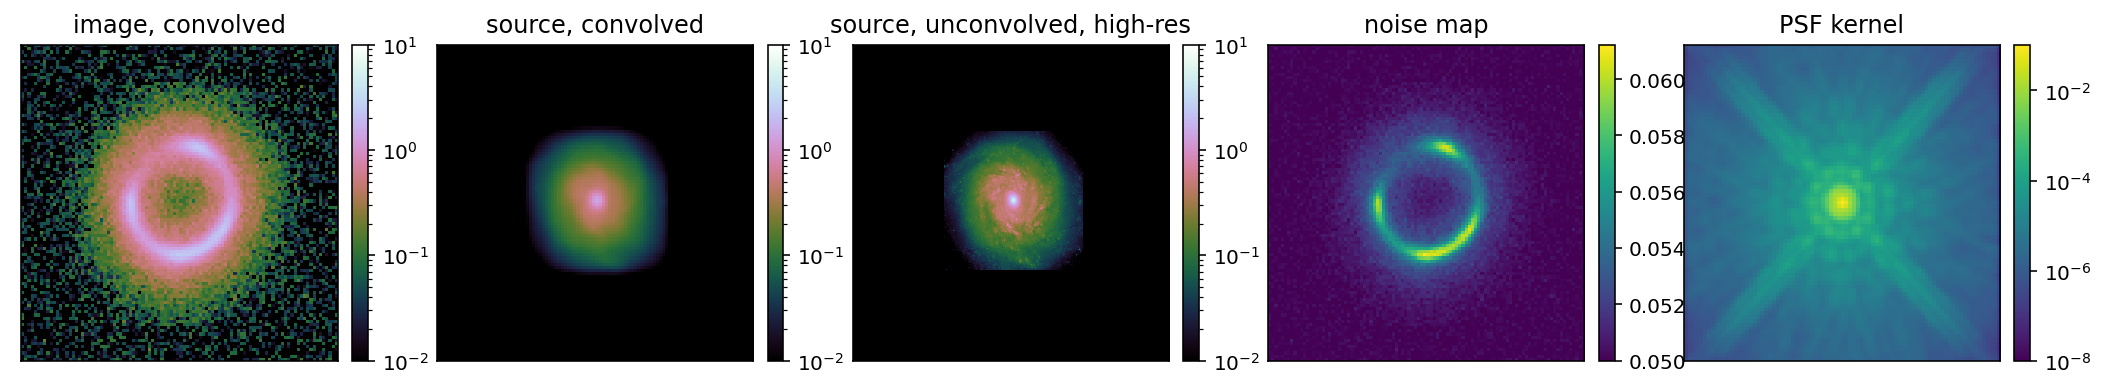

In [10]:
fig = plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 5, 1)
ax.set_title("image, convolved")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(data_class.data, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 2)
ax.set_title("source, convolved")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
source_sim_data_res_conv = imsim_class.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=False)
im = ax.imshow(source_sim_data_res_conv, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 3)
ax.set_title("source, unconvolved, high-res")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 4)
ax.set_title("noise map")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(np.sqrt(data_class.C_D), origin='lower', cmap=cmap_default)
nice_colorbar(im)

ax = plt.subplot(1, 5, 5)
ax.set_title("PSF kernel")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(psf_class.kernel_point_source, origin='lower', 
               cmap=cmap_default, norm=LogNorm(1e-8))
nice_colorbar(im)

plt.show()

## Reconstruction of the source galaxy

We perform the reconstruction using two methods:
- "pixel-based" using the new `'SLIT_STARLETS'` profile
- "analytical" using the `'SHAPELETS'` and optionally `'SERSIC_ELLIPSE'` profiles

### Optionally setup a mask for exclude pixels from the likelihood

In [11]:
# you can set any mask on imaging data here (binary array, 0s are masked pixels)
if data_type == 'HST':
    image_mask = np.ones((num_pix, num_pix))
else:
    image_mask = mask_util.mask_sphere(ra_grid_2d, dec_grid_2d, 0, 0, 3.2)
    plt.figure()
    plt.imshow(data_class.data, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
    plt.imshow(image_mask, origin='lower', cmap='gray', alpha=0.2)
    plt.show()

#### Results will be saved in these dictionnaries

In [12]:
all_results = {}
all_timings = {}

### Pixel-based starlets reconstruction

#### Define a function that runs the pixel-based reconstruction

In [13]:
def run_pixelbased_modelling(class_list, kwargs_lens, ss_factor_source, 
                             num_starlet_scales=6, show_results=True, verbose=True, 
                             noise_seed=None):
    _, data_class, psf_class, lens_model_class, _ = class_list
    
    # setup sparse modelling
    source_model_list_sparsefit = ['SLIT_STARLETS']
    kwargs_starlets_source = {'n_scales': num_starlet_scales, 'n_pixels': (num_pix*ss_factor_source)**2}
    kwargs_source_sparsefit = [kwargs_starlets_source]
    source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

    ss_factor_image = 1
    kwargs_numerics_sparsefit = {'supersampling_factor': ss_factor_image}
    
    kwargs_special_sparsefit = {
        'delta_x_source_grid': 0,
        'delta_y_source_grid': 0,
    }

    kwargs_sparse_solver = {
        'supersampling_factor_source': ss_factor_source,
        'minimal_source_plane': True,
        'min_num_pix_source': 30,
        'min_threshold': 3,
        'threshold_increment_high_freq': 1,
        'threshold_decrease_type': 'exponential',
        'include_regridding_error': False,
        'sparsity_prior_norm': 1,
        'num_iter_source': 20,
        'num_iter_weights': 3,
        'verbose': verbose,
        'show_steps': False,
        'thread_count': 8,  # number of processors
    }

    imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                    lens_model_class=lens_model_class,
                                    source_model_class=source_model_class_sparsefit,
                                    likelihood_mask=image_mask,
                                    kwargs_numerics=kwargs_numerics_sparsefit,
                                    kwargs_sparse_solver=kwargs_sparse_solver)

    # launch solver
    start_time = time.time()
    solver_results = imageSparseFit.image_sparse_solve(kwargs_lens=kwargs_lens, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_special=kwargs_special_sparsefit)
    end_time = time.time()
    timing = end_time-start_time
    if verbose:
        print("Runtime : {:.3f} s".format(timing))

    sparseSolver = imageSparseFit.sparseSolver
    
    # display summary plot
    if show_results:
        fig = sparseSolver.plot_results(log_scale=True, fontsize=16,
                                        vmin_res=-6, vmax_res=6,
                                        vmin_image=10**(-2), vmax_image=10**(1), 
                                        vmin_source=10**(-2), vmax_source=10**(1))
        plt.show()

    # get model maps
    image_model = sparseSolver.image_model(unconvolved=False)
    if kwargs_sparse_solver['minimal_source_plane'] is True:
        ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
        source_grid = RegularGrid(num_pix, num_pix, data_class.transform_pix2angle, 
                                  ra_at_xy_0, dec_at_xy_0, 
                                  supersampling_factor=supersampling_factor_source)
        ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate
        source_model = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
        source_model = lenstro_util.array2image(source_model)
    else:
        source_model = sparseSolver.source_model
        
    source_model_data_res = imageSparseFit.source_surface_brightness(kwargs_source_sparsefit,
                                                                     de_lensed=True, unconvolved=True)
    
    return data_class.data, image_model, source_model, source_model_data_res, timing


#### Runs the reconstruction or load it from backup file

In [14]:
model_type = 'starlets'
path_backup = os.path.join('backups', 'backup-src-recon_data-{}_mocksource-{}_model-{}_ssres-{}.pkl'
                           .format(data_type, complex_source_type, model_type, supersampling_factor_source))

if solve_pixelbased:
    
    # run the computation
    image_sim, image_model, source_model, source_model_data_res, timing \
        = run_pixelbased_modelling(class_list, kwargs_lens, 
                                   supersampling_factor_source,
                                   num_starlet_scales=6)
    
    # save results for comparison
    all_timings[model_type] = timing
    all_results[model_type] = (image_model, source_model, source_model_data_res)

    # pickle for backup
    data_backup = [image_sim, source_sim_comp, source_sim_data_res, image_model, source_model, source_model_data_res, timing]
    with open(path_backup, 'wb') as handle:
        pkl.dump(data_backup, handle)
    
else:
    try:
        data_backup = pkl.load(open(path_backup, 'rb'))
    except FileNotFoundError:
        print("Could not load data from backup: '{}'".format(path_backup))
        all_results[model_type] = None
        all_timings[model_type] = None
    else:
        print("Loaded data from backup: '{}'".format(path_backup))
        all_results[model_type] = (data_backup[3], data_backup[4], data_backup[5])
        all_timings[model_type] = data_backup[-1]

Loaded data from backup: 'backups/backup-src-recon_data-HST_mocksource-highres-single_model-starlets_ssres-3.pkl'


### Analytical shapelets reconstruction

#### Define functions for automatic refinement of multiple shapelets basis

In [15]:
def find_components(image, min_size_arcsec=0.3, thresh=0.4, show_locations=False):
    """
    Detect multiple components in a pixelated model of the source and return their coordinates.
    min_size_arcsec: minimum size of features to be considered as individual components
    thresh: threshold all values below `tresh` times the max of the image after LoG filtering
    """
    from scipy.ndimage import gaussian_laplace
    from skimage.feature import peak_local_max

    # convert minimum component size in pixel units
    min_size = int(min_size_arcsec / data_class.pixel_width)
    # downscale source image to data resolution (for speed + easier for converting to data units)
    down = image_util.re_size(image, factor=supersampling_factor_source)
    # apply laplacian of gaussian (LoG) filter to enhance maxima
    filtered = - gaussian_laplace(down, sigma=min_size, mode='constant', cval=0.)
    # assume all value below max*threshold can not be maxima, so put all to zero
    filtered[filtered < thresh*filtered.max()] = 0.
    # find coordinates of local maxima
    max_idx_2d = peak_local_max(filtered, min_distance=min_size)
    x_list, y_list = max_idx_2d[:, 1], max_idx_2d[:, 0]
    # convert pixel coordinates to physical coordinates
    ra_list, dec_list = data_class.map_pix2coord(x_list, y_list)
    # show maxima on image for debug
    if show_locations:
        fig = plt.figure(figsize=(3, 3))
        plt.imshow(down, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
        for i in range(len(x_list)):
            plt.scatter([x_list[i]], [y_list[i]], c='red', s=60, marker='+')
            plt.annotate(i+1, (x_list[i], y_list[i]), color='red')
        plt.text(1, 1, "detected source components", color='white')
        fig.axes[0].get_xaxis().set_visible(False); fig.axes[0].get_yaxis().set_visible(False)
        plt.show()
    return (x_list, y_list), (ra_list, dec_list)

def setup_shapelets_profiles(ra_list, dec_list, n_max_list, init_scale=0.3, 
                             fix_multiple_r_eff=False, fix_centroids=False):
    """
    Initialize lenstronomy data containers for multiple shapelets basis.
    fix_multiple_r_eff: if True, when multiple source components, fix R_sersic of potential Sersic profiles to elimitate degeneracies.
    fix_centroids: if True, fixes centroids of all components.
    """
    num_basis = len(ra_list)
    light_model_list_setup = []
    kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, \
        kwargs_source_lower, kwargs_source_upper = [], [], [], [], []
    joint_source_with_source = []
    shapelets_index_list = []
    profile_idx = 0
    for i in range(num_basis):
        # add shapelets basis
        light_model_list_setup.append('SHAPELETS')
        kwargs_source_init.append({'beta': init_scale, 'center_x': ra_list[i], 'center_y': dec_list[i]})
        kwargs_source_sigma.append({'beta': 0.05, 'center_x': 0.05, 'center_y': 0.05})
        kwargs_source_fixed.append({'n_max': n_max_list[i]})
        if fix_centroids:
            kwargs_source_fixed[-1].update({'center_x': ra_list[i], 'center_y': dec_list[i]})
        kwargs_source_lower.append({'beta': 0.01, 'center_x': ra_list[i]-0.1, 'center_y': dec_list[i]-0.1})
        kwargs_source_upper.append({'beta': 2, 'center_x': ra_list[i]+0.1, 'center_y': dec_list[i]+0.1})
        shapelets_idx = profile_idx
        shapelets_index_list.append(shapelets_idx)
        profile_idx += 1
        
        # add Sersic profiles if required
        if with_sersic:
            light_model_list_setup.append('SERSIC_ELLIPSE')
            kwargs_source_init.append({'R_sersic': init_scale, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': ra_list[i], 'center_y': dec_list[i]})
            kwargs_source_sigma.append({'R_sersic': 0.05, 'n_sersic': 0.05, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
            kwargs_source_fixed.append({})
            if fix_multiple_r_eff and num_basis > 1:
                kwargs_source_fixed[-1].update({'R_sersic': init_scale})
            if fix_centroids:
                kwargs_source_fixed[-1].update({'center_x': ra_list[i], 'center_y': dec_list[i]})
            kwargs_source_lower.append({'R_sersic': 0.01, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': ra_list[i]-0.1, 'center_y': dec_list[i]-0.1})
            kwargs_source_upper.append({'R_sersic': 2, 'n_sersic': 8, 'e1': 0.5, 'e2': 0.5, 'center_x': ra_list[i]+0.1, 'center_y': dec_list[i]+0.1})
            sersic_idx = profile_idx
            profile_idx += 1
            
            # in case of Sersic+shapelets, add constraint on joint centroids
            joint_source_with_source.append([sersic_idx, shapelets_idx, ['center_x', 'center_y']])
    
    return (light_model_list_setup, kwargs_source_init, kwargs_source_sigma, 
            kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper, joint_source_with_source), shapelets_index_list

def update_shapelets_orders(n_max_list, ra_list, dec_list, image_model, done_list=None, 
                            size_arcsec_list=None, show_regions=False):
    """
    Based on model residuals in the vicinity of lensed components, find optimal n_max for each shapelets basis.
    """
    from lenstronomy.LightModel.Profiles.interpolation import Interpol
    
    # compute model residuals
    residuals = (image_model - image_sim) / noise_map_sim * image_mask
    
    # ray-shoot coordinates
    ra_grid_rs, dec_grid_rs = lens_model_class.ray_shooting(ra_grid, dec_grid, kwargs_lens)
    
    num_basis = len(ra_list)
    if show_regions:
        fig, axes = plt.subplots(1, num_basis, figsize=(12, 3))
    
    n_max_list_updated = copy.deepcopy(n_max_list)
    if done_list is None:
        done_list = [False] * num_basis
    if size_arcsec_list is None:
        size_arcsec_list = [0.8] * num_basis  # default components size in source plane
        
    for i in range(num_basis):
        if show_regions:
            ax = axes if len(ra_list) == 1 else axes[i]
            imr = ax.imshow(residuals, origin='lower', cmap=cmap_residuals, vmin=-3, vmax=3)
            nice_colorbar_residuals(imr, residuals, -3, 3, pad=0, size='3%', label='')
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # define a disk profile in source plane as an interpolation of the mask
        mask_src = mask_util.mask_sphere(ra_grid_2d, dec_grid_2d, ra_list[i], dec_list[i], size_arcsec_list[i])
        disk_profile = Interpol()
        kwargs_disk = {'image': mask_src, 'center_x': 0, 'center_y': 0, 'scale': delta_pix,  'phi_G': 0, 'amp': 1}
        
        # lens the disk it with lens model
        mask_1d = disk_profile.function(ra_grid_rs, dec_grid_rs, **kwargs_disk)
        mask = lenstro_util.array2image(mask_1d)
        
        # in case of overlapping mask components, make sure max value is 1 (ensure proper mask union)
        mask[mask > 1] = 1
        
        if show_regions:
            mask_overlay = mask.copy()
            mask_overlay[mask == 1] = np.nan
            im = ax.imshow(mask, origin='lower', cmap='gray', alpha=0.5)
            #nice_colorbar(im, pad=0)
        
        # compute reduced chi2 metric within this mask
        n_mask = np.sum(mask)
        red_chi2_mask = np.sum((residuals*mask)**2) / n_mask
        
        if show_regions:
            ax.text(1, 1, "component {}, chi2={:.3f}".format(i+1, red_chi2_mask), color='white')
        
        # from the chi2, estimate the required shapelet polynomial order n_max
        n_max = n_max_list_updated[i] # start with original value
        
        # update the order
        if red_chi2_mask <= 1.1 or done_list[i] is True:
            # keep same n_max as before, and make sure it's never updated in future calls
            done_list[i] = True
        else:
            # the following update rule is empirical, and requires some sort of calibration
            n_max += int(max(1, 10*(red_chi2_mask - 1.1)))
            # however do not go above some fixed value
            n_max_list_updated[i] = min(n_max, maximal_n_max)
    
    if show_regions:
        plt.show()
        
    return n_max_list_updated, done_list

#### Define a fucntion that extract results from analytical reconstructions

Effectively performs the inversion for linear parameters. 

In [16]:
def get_analytical_model(kwargs_data_joint, kwargs_result, show_plots=False):
    multi_band_list = kwargs_data_joint['multi_band_list']
    multi_band_type = kwargs_data_joint['multi_band_type']
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, 
                          arrow_size=0.02, cmap_string="cubehelix", likelihood_mask_list=[image_mask])
    modelBand = MultiBandImageReconstruction(multi_band_list, kwargs_model, kwargs_result, 
                                             multi_band_type=multi_band_type,
                                             kwargs_likelihood={'image_position_likelihood': True,
                                                                'image_likelihood_mask_list': [image_mask]})
    imageModel, _ = modelBand.band_setup(band_index=0)
    #modelband = modelPlot._band_plot_list[0].bandmodel  # I know, bad practice to access private attribute here

    # get the source model at supersampled resolution
    # extract coordinates properties for orientation and pixel to angle conversion
    ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
    transform_pix2angle = data_class.transform_pix2angle

    # from these properties, create grid objects for image plane and source plane
    kwargs_data = multi_band_list[0][0]
    source_grid = RegularGrid(num_pix, num_pix, kwargs_data['transform_pix2angle'], 
                              kwargs_data['ra_at_xy_0'], kwargs_data['dec_at_xy_0'], 
                              supersampling_factor=supersampling_factor_source)
    ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

    # extract 1D coordinates arrays for easy evaluation surface brightness profiles
    image_model = imageModel.image(**kwargs_result)
    source_model = LightModel(kwargs_model['source_light_model_list']).surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_result['kwargs_source'])
    source_model = lenstro_util.array2image(source_model)
    # flux normalization of true source for proper comparison with pixel-based reconstruction
    source_model = source_model * delta_pix**2
    source_model_data_res = imageModel.source_surface_brightness(kwargs_result['kwargs_source'], unconvolved=True, de_lensed=True)
    
    # display summary plots
    if show_plots:
        f, axes = plt.subplots(1, 4, figsize=(18, 3))
        modelPlot.data_plot(ax=axes[0])
        modelPlot.model_plot(ax=axes[1])
        modelPlot.source_plot(ax=axes[2], deltaPix_source=delta_pix/supersampling_factor_source, 
                              numPix=int(num_pix*supersampling_factor_source))
        modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)
        text = r"$\chi^2={:.2f}$".format(modelPlot._band_plot_list[0]._reduced_x2)
        axes[3].text(0.5, 0.1, text, color='black', fontsize=15, 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[3].transAxes, bbox={'color': 'white', 'alpha': 0.8})
        plt.show()

    return image_model, source_model, source_model_data_res


#### Runs the reconstruction or load it from backup files

In [17]:
model_type = ''
if detect_components and refine_shapelets_orders:
    model_type += 'starlets-refined\n'
model_type += 'shapelets'
if with_sersic:
    model_type += '+Sersic'

path_backup = os.path.join('backups', 'backup-src-recon_data-{}_mocksource-{}_model-{}_nmax-{}_sersic-{}_detect-{}_refine-{}_optim-{}.pkl'
                           .format(data_type, complex_source_type, model_type.replace('\n', '+'), 
                                   repr(n_max_list).replace(' ', '').replace(',', '-'), with_sersic, 
                                   detect_components, refine_shapelets_orders, optimizer_type))
    
# detect number and locations of source components, or setup a single fixed components
if detect_components:
    source_pixel = all_results['starlets'][1]
    _, (ra_list, dec_list) = find_components(source_pixel, show_locations=True)
else:
    ra_list, dec_list = [0], [0] #[ra_source], [dec_source]
print("Initial shapelets orders:", n_max_list)

if solve_analytical:
    kwargs_numerics_fit = {'supersampling_factor': 3} if data_type == 'HST' else {'supersampling_factor': 1}
    ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
    transform_pix2angle = data_class.transform_pix2angle
    kwargs_data_fit = {
        'image_data': data_class.data,
        'background_rms': data_class.background_rms,
        'exposure_time': data_class.exposure_map,
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
        'transform_pix2angle': transform_pix2angle,
    }
    kwargs_psf_fit = {
        'psf_type': psf_type,
        'kernel_point_source': psf_kernel,
    }

    kwargs_data_joint = {
        'multi_band_list': [[kwargs_data_fit, kwargs_psf_fit, kwargs_numerics_fit]],
        'multi_band_type': 'single-band',
    }
    kwargs_constraints = {
        'solver_type': 'NONE',
    }
    kwargs_likelihood = {
        'image_position_likelihood': True,
        'image_likelihood_mask_list': [image_mask],
    }

    # we fixed the mass to truth
    kwargs_lens_init = kwargs_lens
    kwargs_lens_fixed = kwargs_lens
    # dont'care about sigmas and bounds because lens mass is fixed here
    kwargs_lens_sigma = kwargs_lens  
    kwargs_lens_lower = kwargs_lens
    kwargs_lens_upper = kwargs_lens
    
    # setup for source light: shapelets (+ Sersic if needed) basis set(s)
    setup_shapelets, shapelets_index_list = setup_shapelets_profiles(ra_list, dec_list, n_max_list, 
                                                                     fix_multiple_r_eff=True, fix_centroids=False) 
    source_light_model_list_fit = setup_shapelets[0]
    kwargs_source_init = setup_shapelets[1]
    kwargs_source_sigma = setup_shapelets[2]
    kwargs_source_fixed = setup_shapelets[3]
    kwargs_source_lower = setup_shapelets[4]
    kwargs_source_upper = setup_shapelets[5]
    kwargs_constraints['joint_source_with_source'] = setup_shapelets[6]
    
    kwargs_model = {
        'lens_model_list': lens_model_list,
        'source_light_model_list': source_light_model_list_fit,
    }
    kwargs_params = {
        'lens_model': [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
        'source_model': [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_source_lower, kwargs_source_upper]
    }
    
    fitSequence = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                                  kwargs_likelihood, kwargs_params)
    
    # launch optimizer (single PSO)
    if optimizer_type == 'SIMPLEX':
        fitting_list_opt = [
            ['SIMPLEX', {'n_iterations': 50, 'method': 'Nelder-Mead'}]
        ]
    elif optimizer_type == 'PSO':
        fitting_list_opt = [
            ['PSO', {'n_particles': 30, 'n_iterations': 50, 'threadCount': 8}]
        ]
        
    start_time = time.time()
    
    # fit the data
    #fitSequence.param_class.print_setting()
    chain_list = fitSequence.fit_sequence(fitting_list_opt)
    
    if refine_shapelets_orders:
        
        # Here we loop on the process of refinement independent shapelet basis sets
        # The criteria here is only a number of maximum steps.
        
        print("*"*80)
        done_list = None
        for refine_count in range(1, max_refine_steps+1):
            kwargs_result_tmp = fitSequence.best_fit()
            image_model_tmp, _, _ = get_analytical_model(kwargs_data_joint, kwargs_result_tmp, show_plots=(refine_count==1))
            n_max_list_refined, done_list = update_shapelets_orders(n_max_list, ra_list, dec_list, image_model_tmp,
                                                                    done_list=done_list, size_arcsec_list=size_list,
                                                                    show_regions=True)
            if np.all(n_max_list_refined == n_max_list):
                continue
            print("Refined shapelets orders (loop {}): {}".format(refine_count, n_max_list_refined))
            n_max_list = n_max_list_refined
            setup_shapelets, shapelets_index_list = setup_shapelets_profiles(ra_list, dec_list, n_max_list,
                                                                             fix_multiple_r_eff=True, fix_centroids=False)
            
            # create a new fitting sequence with fresh initial values (better to make sure you escape the local minimum on previous fit)
            kwargs_params['source_model'] = setup_shapelets[1:6]
            print(kwargs_params['source_model'][0], kwargs_params['source_model'][2])
            fitSequence = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints,
                                          kwargs_likelihood, kwargs_params, verbose=False)
            chain_list = fitSequence.fit_sequence(fitting_list_opt)
        
        if refine_count == max_refine_steps:
            print("Max number refinement steps reached!")
            
        print("*"*80)
    
    end_time = time.time()
    timing = end_time-start_time
    
    all_timings[model_type] = timing
    print("Runtime : {:.3f} s".format(end_time-start_time))
    
    # extract best-fit parameters
    kwargs_result = fitSequence.best_fit()
    print(kwargs_result)
    
    # check PSO convergence plot
    for i in range(len(chain_list)):
        if chain_list[i][0] == 'PSO':
            chain_plot.plot_chain_list(chain_list, i)
    
    image_model, source_model, source_model_data_res = get_analytical_model(kwargs_data_joint, kwargs_result, show_plots=True)
    
    # save for comparison
    all_results[model_type] = (image_model, source_model, source_model_data_res)
    
    # pickle for backup
    data_backup = [image_sim, source_sim_comp, source_sim_data_res, image_model, source_model, source_model_data_res, timing]
    with open(path_backup, 'wb') as handle:
        pkl.dump(data_backup, handle)

else:
    try:
        data_backup = pkl.load(open(path_backup, 'rb'))
    except FileNotFoundError:
        print("Could not load data from backup: '{}'".format(path_backup))
        all_results[model_type] = None
        all_timings[model_type] = None
    else:
        print("Loaded data from backup: '{}'".format(path_backup))
        all_results[model_type] = (data_backup[3], data_backup[4], data_backup[5])
        all_timings[model_type] = data_backup[-1]
    

Initial shapelets orders: [8]
Loaded data from backup: 'backups/backup-src-recon_data-HST_mocksource-highres-single_model-shapelets+Sersic_nmax-[8]_sersic-True_detect-False_refine-False_optim-PSO.pkl'


## Compute some quality metrics

We compare pixel-based and analytical reconstructions using the following metrics, defined in _source plane_.
- SDR : Source Distortion Ratio
- SSIM : Source Similarity Index Metric
- recovered total magnitude

sim total magnitude = 19.613641342226067
=== starlets ===
SDR (Data Resolution) = 9.753321560174275
SDR (DR, RA) = 9.850842894842922
SDR (Supersampled Resolution) = 7.933039878752776
SDR (SR, RA) = 8.091425169418239


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Util/plot_util.py:77: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  base.set_bad(color=base(0))
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Util/plot_util.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  base.set_under(base(0))


SSIM (SR, RA) = 0.9489082
total magnitude = 19.51397086957035
=== shapelets+Sersic ===
SDR (Data Resolution) = 10.085839368074868
SDR (DR, RA) = 10.108584001572217
SDR (Supersampled Resolution) = 8.27221430056105
SDR (SR, RA) = 8.300349199986723
SSIM (SR, RA) = 0.94911635
total magnitude = 19.596102353581983


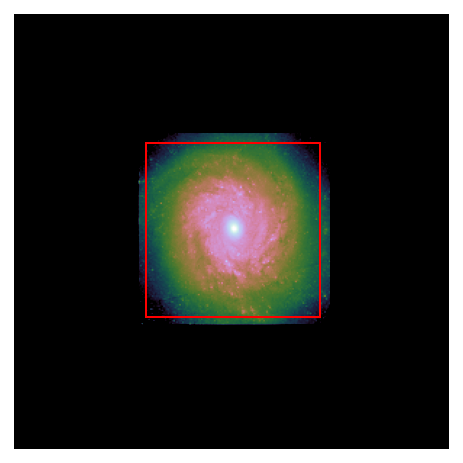

In [18]:
# define a restricted area in source plane for SDR metric
if complex_source_type == 'highres-single':
    if data_type == 'HST':
        idx_ll_x, idx_ll_y, width, height = num_pix_source//3-10, num_pix_source//3-10, num_pix_source//3+20, num_pix_source//3+20
        idx_dr_ll_x, idx_dr_ll_y, width_dr, height_dr = num_pix//3-10, num_pix//3-10, num_pix//3+20, num_pix//3+20
    elif data_type == 'ELT':
        idx_ll_x, idx_ll_y, width, height = num_pix_source//3, num_pix_source//3, num_pix_source//3, num_pix_source//3 #1200, 1200, 1500, 1500
if complex_source_type == 'highres-group':
    if data_type == 'HST':
        idx_ll_x, idx_ll_y, width, height = num_pix_source//3-30, num_pix_source//3-30, num_pix_source//3+40, num_pix_source//3+40
        
# visualize the area
fig, axes = plt.subplots(1, 1)
ax = axes
ax.axis('off')
ax.imshow(source_sim_comp, origin='lower', cmap=log_cmap('cubehelix', 1e-3, 1))
rect = mpatches.Rectangle((idx_ll_x, idx_ll_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)


sim_mag_tot = metrics_util.total_mag(source_sim_comp, zero_point=kwargs_simulation['magnitude_zero_point'])
print("sim total magnitude =", sim_mag_tot)

# print some metrics
all_sdr = {}
all_mag = {}
for model_type, results in all_results.items():
    if results is not None:
        print("=== {} ===".format(model_type))
        image_model, source_model, source_model_data_res = results
        
        print("SDR (Data Resolution) =", metrics_util.SDR(source_sim_data_res, source_model_data_res))
        
        sdr_restric_data_res = metrics_util.SDR(source_sim_data_res[idx_dr_ll_y:idx_dr_ll_y+height_dr, idx_dr_ll_x:idx_dr_ll_x+width_dr], 
                                                source_model_data_res[idx_dr_ll_y:idx_dr_ll_y+height_dr, idx_dr_ll_x:idx_dr_ll_x+width_dr])
        print("SDR (DR, RA) =", sdr_restric_data_res)
        
        print("SDR (Supersampled Resolution) =", metrics_util.SDR(source_sim_comp, source_model))

        sdr_restric = metrics_util.SDR(source_model[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width], 
                                       source_sim_comp[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width])
        print("SDR (SR, RA) =", sdr_restric)
        
        print("SSIM (SR, RA) =", metrics_util.SSIM(source_sim_comp[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width], 
                                                            source_model[idx_ll_y:idx_ll_y+height, idx_ll_x:idx_ll_x+width]))
        
        all_sdr[model_type] = sdr_restric
        
        # compute total magnitude in source plane
        mag_tot = metrics_util.total_mag(source_model, zero_point=kwargs_simulation['magnitude_zero_point'])
        print("total magnitude =", mag_tot)
        all_mag[model_type] = mag_tot
        

## Generate final plots

#### Define utility functions to scale bar, texts, ...

In [19]:
def add_scale_bar(ax, image_size, pixel_size, size_arcsec=1, color='white', fontsize=16):
    bott_left_x, bott_left_y = 0.08*image_size, 0.08*image_size
    width, height = float(size_arcsec)/pixel_size, 0.1/pixel_size
    bar = mpatches.Rectangle((bott_left_x, bott_left_y), width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 0.2/pixel_size
    text = '{}"'.format(size_arcsec)
    ax.text(bott_left_x+width/2., bott_left_y+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16, txt_color='black', bg_color='white'):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    ax.text(x, y, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})
    
# flux value limits
image_vmin  = 1e-2
image_vmax  = 6e0
source_vmin = 1e-2
source_vmax = 6e0 #source_sim_comp.max() #* 10**(0.2)

# residuals value limits (symmetric)
image_clim  = 6    # in noise units
source_clim = 0.4  # in (arbitrary) flux units

### Simulated data plot 

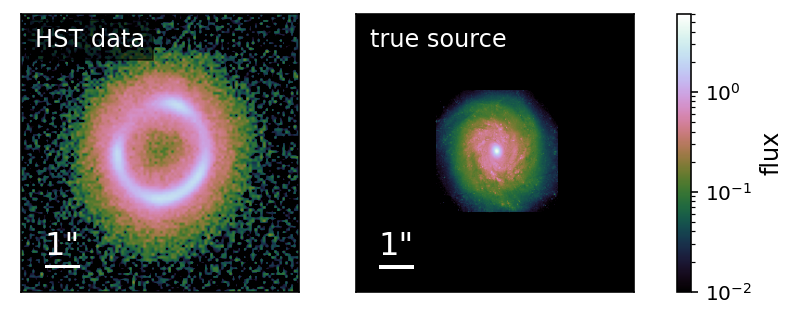

In [20]:
if data_type == 'ELT':
    data_title = "E-ELT data"
elif data_type == 'HST':
    data_title = "HST data"

if data_type == 'HST':
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    
    # plot 0a: imaging data
    ax = axes[0]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, data_title, fontsize=12)
    add_scale_bar(ax, num_pix, delta_pix)
    im = ax.imshow(data_class.data * image_mask, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(image_vmin, image_vmax))
    nice_colorbar(im, label="flux", pad=0.3, fontsize=12, invisible=True)

    # plot 0b: true source
    ax = axes[1]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "true source", fontsize=12)
    add_scale_bar(ax, num_pix*supersampling_factor_source, delta_pix/supersampling_factor_source)
    #add_text_box(ax, r"mag$=${:.2f}".format(mag_source), fontsize=12, loc='right')
    im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(source_vmin, source_vmax))
    nice_colorbar(im, label="flux", pad=0.3, fontsize=12)

    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
    plt.show()

elif data_type == 'ELT':
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    # plot 0a: imaging data
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, data_title, fontsize=12)
    add_scale_bar(ax, num_pix, delta_pix)
    im = ax.imshow(image_sim * image_mask, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(image_vmin, image_vmax))
    nice_colorbar(im, label="flux", pad=0.3, fontsize=12)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
    plt.show()

fig_name = 'data-{}_mocksource-{}.pdf'.format(data_type, complex_source_type)
fig_path = os.path.join('figures', fig_name)
#fig.savefig(fig_path, dpi=100, bbox_inches='tight')

### Source reconstruction results plot

runtime for 'starlets': 1.7265429496765137s


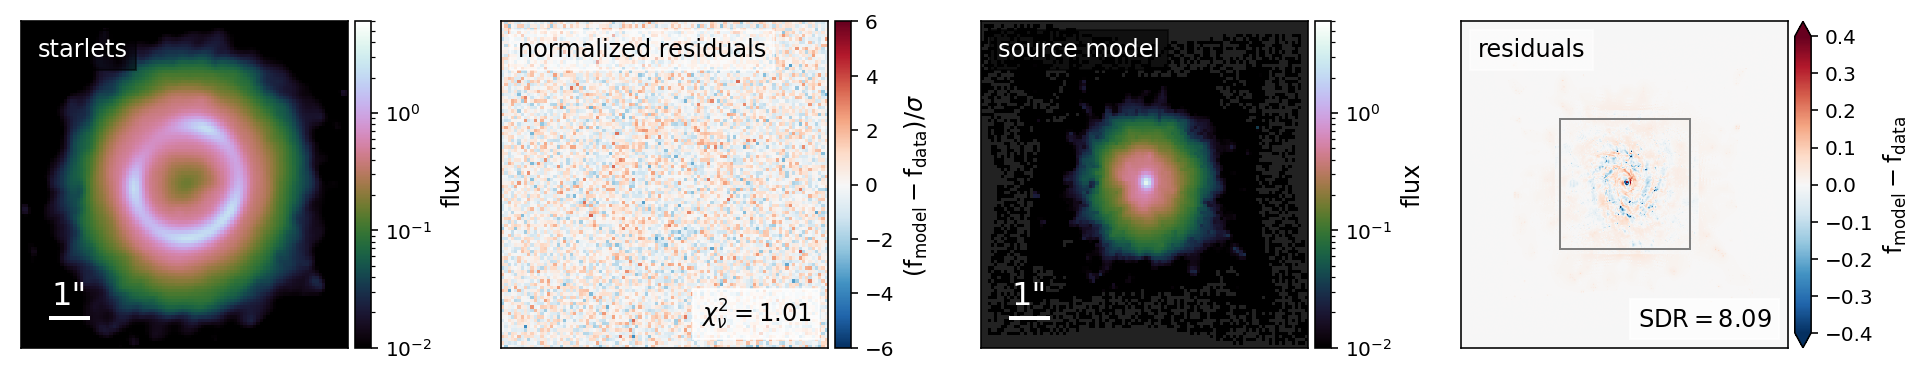

runtime for 'shapelets+Sersic': 92.12807297706604s


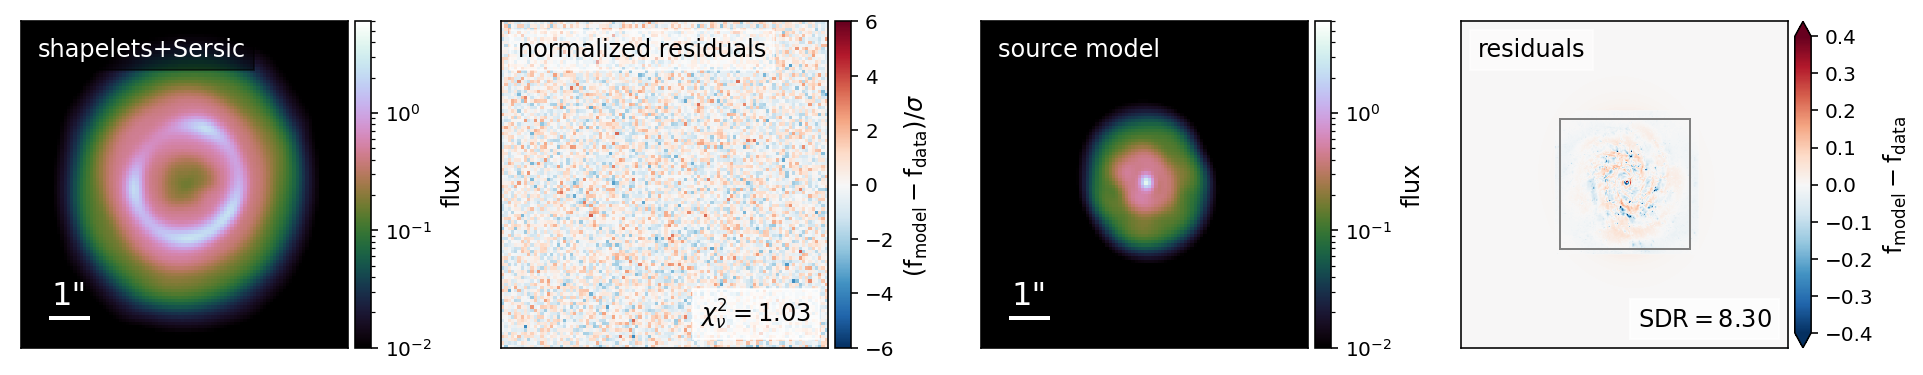

In [21]:
for model_type, model_results in all_results.items():
    
    fig, axes = plt.subplots(1, 4, figsize=(17, 3))
    
    image_model, source_model, source_model_data_res = model_results
    timing = all_timings[model_type]
    
    print("runtime for '{}': {}s".format(model_type, timing))
    
    # plot 1: image model
    ax = axes[0]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "{}".format(model_type), fontsize=12)
    add_scale_bar(ax, len(image_model), delta_pix)
    im = ax.imshow(image_model * image_mask, origin='lower', cmap=cmap_flux_with_neg,
                   norm=LogNorm(image_vmin, image_vmax))
    nice_colorbar(im, label="flux", pad=0.05, fontsize=12)
    
    # plot 2: image normalized residuals
    image_red_res = (image_model - data_class.data) / np.sqrt(data_class.C_D) * image_mask
    num_data_points = image_red_res[image_mask == 1].size
    ax = axes[1]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "normalized residuals", fontsize=12, txt_color='black', bg_color='white')
    im = ax.imshow(image_red_res, origin='lower', cmap=cmap_residuals, 
                   vmin=-image_clim, vmax=image_clim)
    add_text_box(ax, r"$\chi^2_\nu=${:.2f}".format(metrics_util.chi2_nu(image_red_res, num_data_points)), 
                 fontsize=12)
    nice_colorbar_residuals(im, image_red_res, -image_clim, image_clim, pad=0.05, fontsize=12,
                            label=r"$({\rm f}_{\rm model}-{\rm f}_{\rm data})/\sigma$")
    
    # plot 3: source model
    ax = axes[2]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "source model", fontsize=12)
    add_scale_bar(ax, num_pix, delta_pix)
    im = ax.imshow(source_model_data_res, origin='lower', cmap=cmap_flux_with_neg,
                   norm=LogNorm(source_vmin, source_vmax))
    nice_colorbar(im, label="flux", pad=0.05, fontsize=12)
    
    # plot 4: source residuals
    source_res = source_model - source_sim_comp
    #source_res = source_model_data_res - source_sim_data_res
    
    ax = axes[3]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "residuals", fontsize=12, txt_color='black', bg_color='white')
    im = ax.imshow(source_res, origin='lower', cmap=cmap_residuals, 
                   vmin=-source_clim, vmax=source_clim)
    rect = mpatches.Rectangle((idx_ll_x, idx_ll_y), width, height, linewidth=1, linestyle='-',
                             edgecolor='gray', facecolor='none')
    ax.add_patch(rect)
    add_text_box(ax, r"SDR$=${:.2f}".format(all_sdr[model_type]), fontsize=12)
    nice_colorbar_residuals(im, source_res, -source_clim, source_clim, pad=0.05, fontsize=12,
                            label=r"${\rm f}_{\rm model}-{\rm f}_{\rm data}$")
    
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)
    plt.show()

    if model_type == 'starlets':
        fig_name = ('data-{}_mocksource-{}_model-{}_ssres-{}_time-{:.2e}.pdf'
                .format(data_type, complex_source_type, model_type, supersampling_factor_source, timing))
    else:
        fig_name = ('data-{}_mocksource-{}_model-{}_nmax-{}_sersic-{}_detect-{}_refine-{}_optim-{}_time-{:.2e}.pdf'
                    .format(data_type, complex_source_type, model_type.replace('\n', '+'), 
                            repr(n_max_list).replace(' ', '').replace(',', '-'),
                            with_sersic, detect_components, refine_shapelets_orders, 
                            optimizer_type, timing))
    fig_path = os.path.join('figures', fig_name)
    #fig.savefig(fig_path, dpi=100, bbox_inches='tight')

<div class="alert alert-warning">
Warning: you may notice that residuals shown by lenstronomy plotting routines are not equivalent to the plot right above. This is because the (Poisson) noise covariance is computed differently: in the lenstronomy plotting routines, the noise covariance is re-computed before plotting based on the *modelled* surface brightness, whereas here we stick to the *data* noise covariance.
</div>

### Zoom on reconstructions (E-ELT data only)

In [22]:
img_lim = (1.2*num_pix_source//4, 2.8*num_pix_source//4)
img_lim_data_res = (1.2*num_pix//4, 2.8*num_pix//4)

if data_type == 'ELT':
    
    _, source_model_starlets, _ = all_results['starlets']
    _, source_model_shapelets, _ = all_results['shapelets+Sersic']
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # plot: true source
    ax = axes[2]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "true source", fontsize=12)
    im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(source_vmin, source_vmax))
    #nice_colorbar(im, label="flux", pad=0.2, fontsize=12, invisible=True) #position='bottom', colorbar_kwargs={'orientation': 'horizontal'})
    ax.set_xlim(*img_lim)
    ax.set_ylim(*img_lim)

    # plot: reconstructed source
    ax = axes[0]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "starlets model\n(de-lensed, unconvolved)", fontsize=12)
    im = ax.imshow(source_model_starlets, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(source_vmin, source_vmax))
    #nice_colorbar(im, label="flux", pad=0.2, fontsize=12, invisible=True) #position='bottom', colorbar_kwargs={'orientation': 'horizontal'})
    ax.set_xlim(*img_lim)
    ax.set_ylim(*img_lim)
    
    # plot: reconstructed source with shapelets+Sersic
    ax = axes[1]
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    add_title_box(ax, "shapelets+Sersic model\n(de-lensed, unconvolved)", fontsize=12)
    im = ax.imshow(source_model_shapelets, origin='lower', cmap=cmap_flux,
                   norm=LogNorm(source_vmin, source_vmax))
    #nice_colorbar(im, label="flux", pad=0.2, fontsize=12, invisible=True) #position='bottom', colorbar_kwargs={'orientation': 'horizontal'})
    ax.set_xlim(*img_lim)
    ax.set_ylim(*img_lim)
    
    # plot: true source convolved
    #ax = axes[1, 1]
    #ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    #add_title_box(ax, "true source (convolved)", fontsize=12)
    #im = ax.imshow(source_sim_data_res_conv_comp, origin='lower', cmap=cmap_flux,
    #               norm=LogNorm(source_vmin, source_vmax))
    ##nice_colorbar(im, label="flux", pad=0.2, fontsize=12, invisible=True) #position='bottom', colorbar_kwargs={'orientation': 'horizontal'})
    #ax.set_xlim(*img_lim_data_res)
    #ax.set_ylim(*img_lim_data_res)
    
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
    plt.show()
    
    fig_name = 'data-{}_mocksource-{}_zoom.pdf'.format(data_type, complex_source_type)
    fig_path = os.path.join('figures', fig_name)
    #fig.savefig(fig_path, dpi=100, bbox_inches='tight')

### Influence of number of starlet decomposition scales

#### Simulate data with different noise realisations, and reconstruct the source for different $r_{\rm pix}$ and $J_\mathsf{s}$

If `load_backup` is `True`, reads from backup file for time saving.

In [23]:
load_backup = True  # to save time (depending on parameters, the 3 nested loop takes a while)
backup_path_Js = os.path.join('backups', 'backup_starlet_Js.pkl')

ss_source_range = list(range(2, 5))
starlet_scale_range = list(range(3, 9))
noise_seed_range = list(range(10))
all_ranges = [ss_source_range, starlet_scale_range, noise_seed_range]

if data_type == 'HST' and not load_backup:
    progressbar = tqdm(desc="noise realisations", total=len(noise_seed_range))

    timings_list, sdrs_list, sdrs_datares_list, chi2s_list = [], [], [], []
    for r_pix in ss_source_range:
        #print("image to source resolution: {}".format(r_pix), end='\r', flush=True)
        
        timings, sdrs, sdrs_dr, chi2s = [], [], [], []
        for J_s in starlet_scale_range:
            #print("number of starlet scales: {}".format(J_s), end='\r', flush=True)
            
            progressbar.reset()
            desc = "r_pix={}/{}, J_s={}/{}, varying noise".format(r_pix, starlet_scale_range[-1], 
                                                            J_s, starlet_scale_range[-1])
            progressbar.set_description_str(desc=desc, refresh=True)
            timing_sub, sdr_sub, sdr_dr_sub, chi2_sub = [], [], [], []
            for seed in noise_seed_range:
                _, image_model, source_model, source_model_data_res, timing \
                    = run_pixelbased_modelling(class_list, kwargs_lens, r_pix, 
                                               num_starlet_scales=J_s, 
                                               show_results=False, verbose=False,
                                               noise_seed=seed)
                data_class = class_list[1]

                timing_sub.append(timing)
                sdr = metrics_util.SDR(source_sim_comp, source_model)
                sdr_sub.append(sdr)
                sdr_dr = metrics_util.SDR(source_sim_data_res, source_model_data_res)
                sdr_dr_sub.append(sdr_dr)
                image_red_res = (image_model - data_class.data) / np.sqrt(data_class.C_D) * image_mask
                num_data_points = image_red_res[image_mask == 1].size
                chi2 = metrics_util.chi2_nu(image_red_res, num_data_points)
                chi2_sub.append(chi2)
                progressbar.update()
            
            progressbar.refresh()
            
            timings.append([np.mean(timing_sub), np.std(timing_sub)])
            sdrs.append([np.mean(sdr_sub), np.std(sdr_sub)])
            sdrs_dr.append([np.mean(sdr_dr_sub), np.std(sdr_dr_sub)])
            chi2s.append([np.mean(chi2_sub), np.std(chi2_sub)])
            
        timings_list.append(np.array(timings))
        sdrs_list.append(np.array(sdrs))
        sdrs_datares_list.append(np.array(sdrs_dr))
        chi2s_list.append(np.array(chi2s))
        
    progressbar.close()
    
    all_lists = [timings_list, sdrs_list, sdrs_datares_list, chi2s_list]
    with open(backup_path_Js, 'wb') as handle:
        pkl.dump([all_ranges, all_lists], handle)
        
else:
    all_ranges, all_lists = pkl.load(open(backup_path_Js, 'rb'))
    timings_list, sdrs_list, sdrs_datares_list, chi2s_list = all_lists

#### Plot results

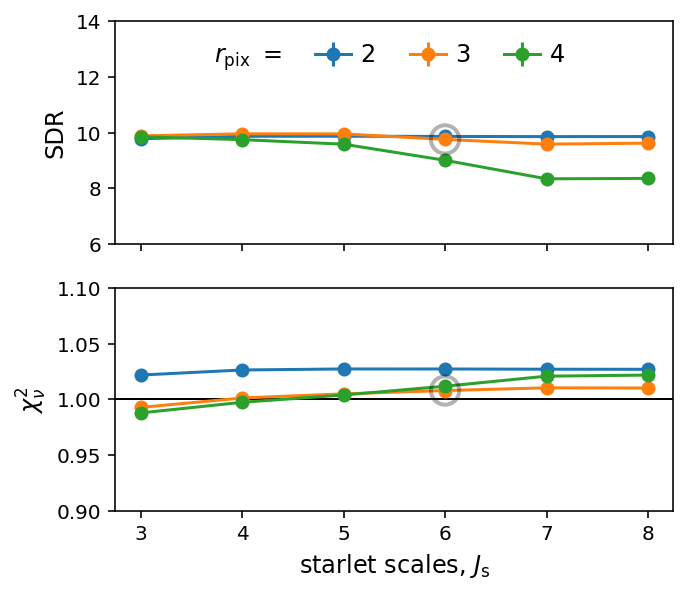

In [24]:
fontsize = 12

show_supersampled_SDR = False
choice_J_s = 6
choice_r_pix = supersampling_factor_source

sdrs_list_plot = sdrs_list if show_supersampled_SDR else sdrs_datares_list


fig, axes = plt.subplots(2, 1, figsize=(5, 4.5), sharex=True)
ax = axes[0]
#ax.text(0.1, 0.1, "SDR", fontsize=16, transform=ax.transAxes)
ax.set_ylabel("SDR", fontsize=fontsize)
ax.set_ylim(6, 14)
ax = axes[1]
#ax.text(0.1, 0.1, r"$\chi^2_\nu$", fontsize=16, transform=ax.transAxes)
ax.set_xlabel(r"starlet scales, $J_\mathsf{s}$", fontsize=fontsize)
ax.set_ylabel(r"$\chi^2_\nu$", fontsize=fontsize)
ax.set_ylim(0.9, 1.1)
ax.set_xticks(starlet_scale_range)
ax.set_xticklabels(starlet_scale_range)
ax.axhline(1, color='black', linewidth=1, alpha=1, zorder=0)
for i, r_pix in enumerate(ss_source_range):
    label = r_pix
    ax = axes[0]
    ax.errorbar(starlet_scale_range, sdrs_list_plot[i][:, 0], yerr=sdrs_list_plot[i][:, 1],
                label=label, marker='o', zorder=1)
    ax = axes[1]
    ax.errorbar(starlet_scale_range, chi2s_list[i][:, 0], yerr=chi2s_list[i][:, 1],
                label=label, marker='o', zorder=1)

# add indicator on chosen J_s
ax = axes[0]
ax.scatter([choice_J_s], 
           [sdrs_list_plot[ss_source_range.index(choice_r_pix)][starlet_scale_range.index(choice_J_s), 0]],
           s=200, facecolors='none', edgecolors='black', linewidth=2, marker='o', alpha=0.3,
           zorder=2)
ax = axes[1]
ax.scatter([choice_J_s], 
           [chi2s_list[ss_source_range.index(choice_r_pix)][starlet_scale_range.index(choice_J_s), 0]],
           s=200, facecolors='none', edgecolors='black', linewidth=2, marker='o', alpha=0.3,
           zorder=2)

legend_handles = [mpatches.Patch(alpha=0, label=r"$r_{\rm pix}\ =$")]
legend_handles += axes[0].get_legend_handles_labels()[0]
axes[0].legend(handles=legend_handles, fontsize=fontsize, ncol=len(legend_handles),
               loc='upper center', handlelength=1.5, frameon=False,
               bbox_to_anchor=(0.45, 1, 0, 0), 
               columnspacing=1.4, handletextpad=0.4)
fig.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

fig_name = 'data-{}_mocksource-{}_starlet-Js.pdf'.format(data_type, complex_source_type)
fig_path = os.path.join('figures', fig_name)
#fig.savefig(fig_path, dpi=100, bbox_inches='tight')

### Compare radial power-spectrum of source light

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


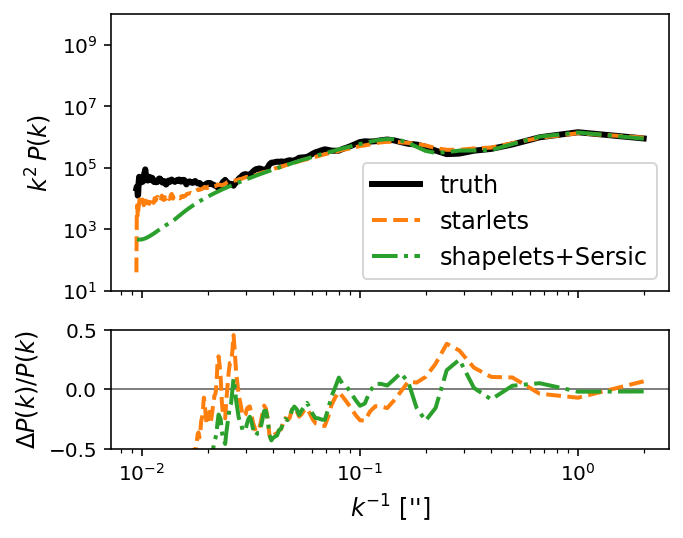

In [25]:
def radial_power_spectrum(img):
    fft = np.fft.fftshift(np.fft.fft2(img))
    p = np.abs(fft)**2
    p_k = image_util.radial_profile(p, center=(p.shape[0]//2, p.shape[1]//2))
    k = np.linspace(0, p_k.shape[0]//2, len(p_k))
    ## alternative method (slower):
    #from lenstronomy.Util import analysis_util
    #ps_r, r = analysis_util.azimuthalAverage(ps)
    return p_k, k

linestyles, colors = ['--', '-.'], ['tab:orange', 'tab:green']

fig, axes = plt.subplots(2, 1, figsize=(5, 4), gridspec_kw={'height_ratios': [0.7, 0.3]}, sharex=True)
true_p_k, true_k = radial_power_spectrum(source_sim_comp)
axes[0].loglog(1./true_k, true_k**2*true_p_k, label="truth", linewidth=3, color='black')
axes[1].axhline(0, linewidth=1, color='gray')
#axes[1].set_yscale('symlog')
for i, (model_type, model_results) in enumerate(all_results.items()):
    image_model, source_model, _ = model_results
    
    model_p_k, k = radial_power_spectrum(source_model)
    axes[0].loglog(1./k, k**2*model_p_k, label=model_type, 
                   linewidth=2, linestyle=linestyles[i], color=colors[i])
    
    #rel_diff = (k**2*model_p_k - true_k**2*true_p_k)/(true_k**2*true_p_k)
    rel_diff = (model_p_k - true_p_k) / true_p_k
    axes[1].semilogx(1./true_k, rel_diff, label=model_type, 
                     linewidth=2, linestyle=linestyles[i], color=colors[i])

axes[0].set_ylim(1e1, 1e10)
axes[1].set_ylim(-0.5, 0.5)
    
#axes[0].invert_xaxis()

axes[1].set_xlabel(r"$k^{-1}$ ['']", fontsize=12)
axes[0].set_ylabel(r"$k^2\,P(k)$", fontsize=12)
axes[1].set_ylabel(r"$\Delta P(k) / P(k)$", fontsize=12)
axes[0].legend(fontsize=12)
plt.show()

fig_name = 'data-{}_mocksource-{}_powerspectrum.pdf'.format(data_type, complex_source_type)
fig_path = os.path.join('figures', fig_name)
#fig.savefig(fig_path, dpi=100, bbox_inches='tight')